<a href="https://colab.research.google.com/github/zahrazfrh733/Tugas-Individu-Deep-Learning/blob/main/Latihan_DL_Per3_VAE_Zahra_Zhafirah_41236819.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt

# ⚙️ Hyperparameters
IMAGE_SHAPE = (28, 28, 1)
LATENT_DIM = 2
EPOCHS = 50
BATCH_SIZE = 128

# 📦 Load dan Preproses Data (Tanpa Padding)
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Tambahkan channel grayscale (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(f"Data shape (28x28): {x_train.shape}")


# 🔄 Reparameterization Trick (tetap sama)
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Data shape (28x28): (60000, 28, 28, 1)


In [ ]:
# 📈 Encoder (28x28 -> 14x14 -> 7x7)
encoder_input = layers.Input(shape=IMAGE_SHAPE, name="encoder_input")
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_input) # Output 14x14
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)             # Output 7x7
shape_before_flattening = x.shape[1:]
x = layers.Flatten()(x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

print("\nEncoder Summary:")
encoder.summary()


Encoder Summary:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      6,274 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      6,274 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,364 (122.52 KB)

 Trainable params: 31,364 (122.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#📉 Decoder (7x7 -> 14x14 -> 28x28)
decoder_input = layers.Input(shape=(LATENT_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# Output akhir 28x28x1 dengan Sigmoid (untuk BCE Loss)
decoder_output = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = models.Model(decoder_input, decoder_output, name="decoder")

print("\nDecoder Summary:")
decoder.summary()


Decoder Summary:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)

            # 1. Reconstruction loss (Binary Cross-Entropy)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction),
                    axis=[1, 2] # Sum over Height and Width
                )
            )
            # 2. KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

# Instansiasi dan Pelatihan
vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.Adam(learning_rate=0.001))

print("\n--- [1. VAE Model] Mulai Pelatihan ---")
# Menggunakan satu argumen karena loss ditangani di train_step
history = vae.fit(x_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
print("--- Pelatihan VAE Selesai ---")


--- [1. VAE Model] Mulai Pelatihan ---
Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - kl_loss: 4.0097 - reconstruction_loss: 367.8612 - total_loss: 371.8709
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 5.7338 - reconstruction_loss: 270.0622 - total_loss: 275.7960
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 5.8843 - reconstruction_loss: 264.4329 - total_loss: 270.3172
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 5.9329 - reconstruction_loss: 262.7469 - total_loss: 268.6798
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 5.9684 - reconstruction_loss: 261.5822 - total_loss: 267.5506
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 6.0052 - reconstruction_loss: 260.7464 - total_loss: 266.7516
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 6.0432 - reconstruction_loss: 259.6266 - total_loss: 265.6698
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 6.0940 - reconstruct


--- [2. Visualisasi Latent Space] ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


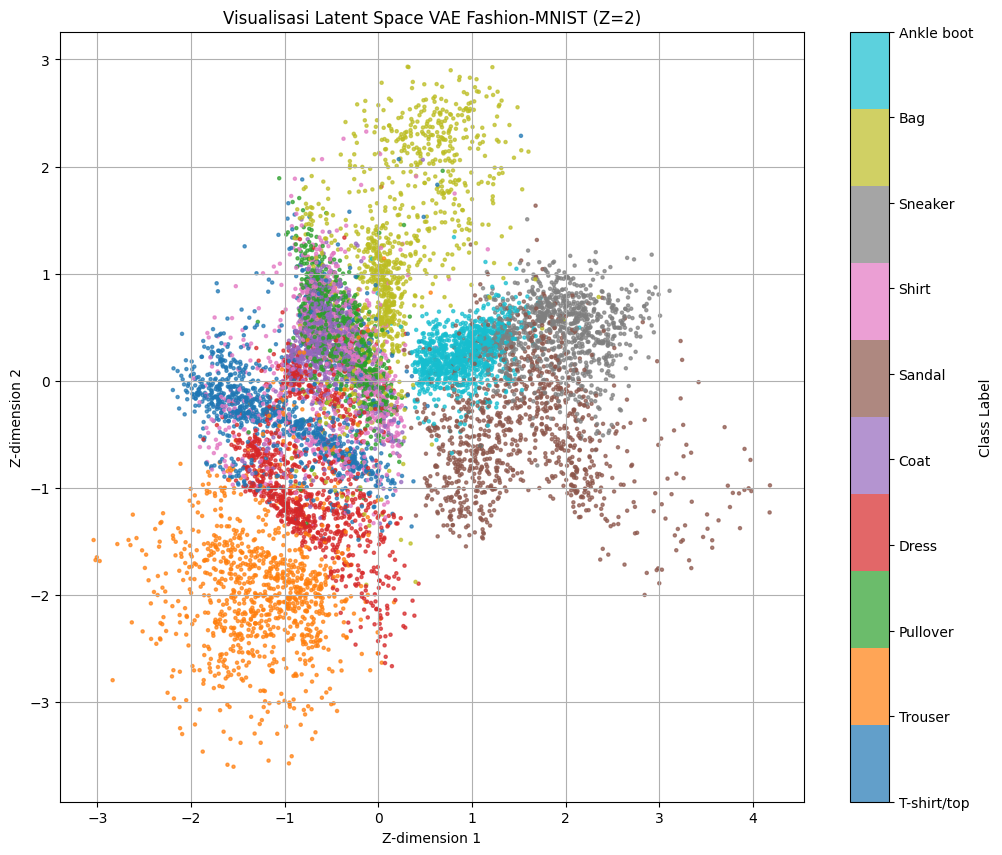

In [ ]:
print("\n--- [2. Visualisasi Latent Space] ---")

# 1. Hitung z_means
# Hanya menggunakan Encoder untuk mendapatkan posisi di latent space
z_means, _, _ = encoder.predict(x_test)

# 2. Plotting (menggunakan label y_test yang sudah dimuat di awal)
fashion_mnist_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_means[:, 0], z_means[:, 1], c=y_test, cmap="tab10", alpha=0.7, s=5)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Visualisasi Latent Space VAE Fashion-MNIST (Z=2)")
cbar = plt.colorbar(scatter)
cbar.set_label("Class Label")
cbar.set_ticks(range(10))
cbar.set_ticklabels(fashion_mnist_labels)
plt.grid(True)
plt.show()


--- [3. Latent Space Arithmetic] Interpolasi ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


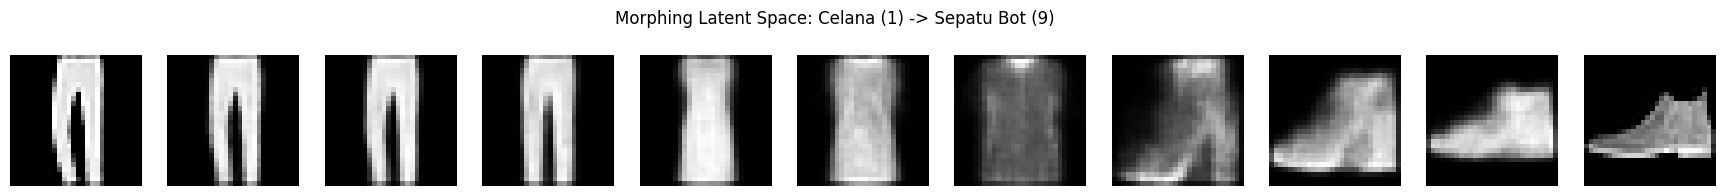

In [ ]:
print("\n--- [3. Latent Space Arithmetic] Interpolasi ---")

def plot_images(images, title="", n_row=1):
    n = len(images)
    plt.figure(figsize=(2 * n, 2 * n_row))
    plt.suptitle(title, y=1.05)
    for i, image in enumerate(images):
        ax = plt.subplot(n_row, n // n_row, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.axis("off")
    plt.show()

# Pilih dua gambar untuk interpolasi (misal: Trouser dan Ankle boot)
idx_A = np.where(y_test == 1)[0][0] # Trouser (Celana)
idx_B = np.where(y_test == 9)[0][0] # Ankle Boot (Sepatu Bot)

img_A = x_test[idx_A]
img_B = x_test[idx_B]

# Encode kedua gambar
z_A, _, _ = encoder.predict(np.expand_dims(img_A, axis=0))
z_B, _, _ = encoder.predict(np.expand_dims(img_B, axis=0))

# Interpolasi Linier
n_steps = 9
interpolated_images = []
alphas = np.linspace(0, 1, n_steps)

for alpha in alphas:
    z_interp = (1 - alpha) * z_A + alpha * z_B
    img_interp = decoder.predict(z_interp)
    interpolated_images.append(img_interp[0])

# Visualisasi Hasil
original_images = [img_A] + interpolated_images + [img_B]
plot_images(original_images, title=f"Morphing Latent Space: Celana ({y_test[idx_A]}) -> Sepatu Bot ({y_test[idx_B]})", n_row=1)


--- [4. Perbandingan VAE vs. AE Biasa] ---
Mulai Pelatihan Autoencoder Biasa...
Pelatihan Autoencoder Biasa Selesai.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


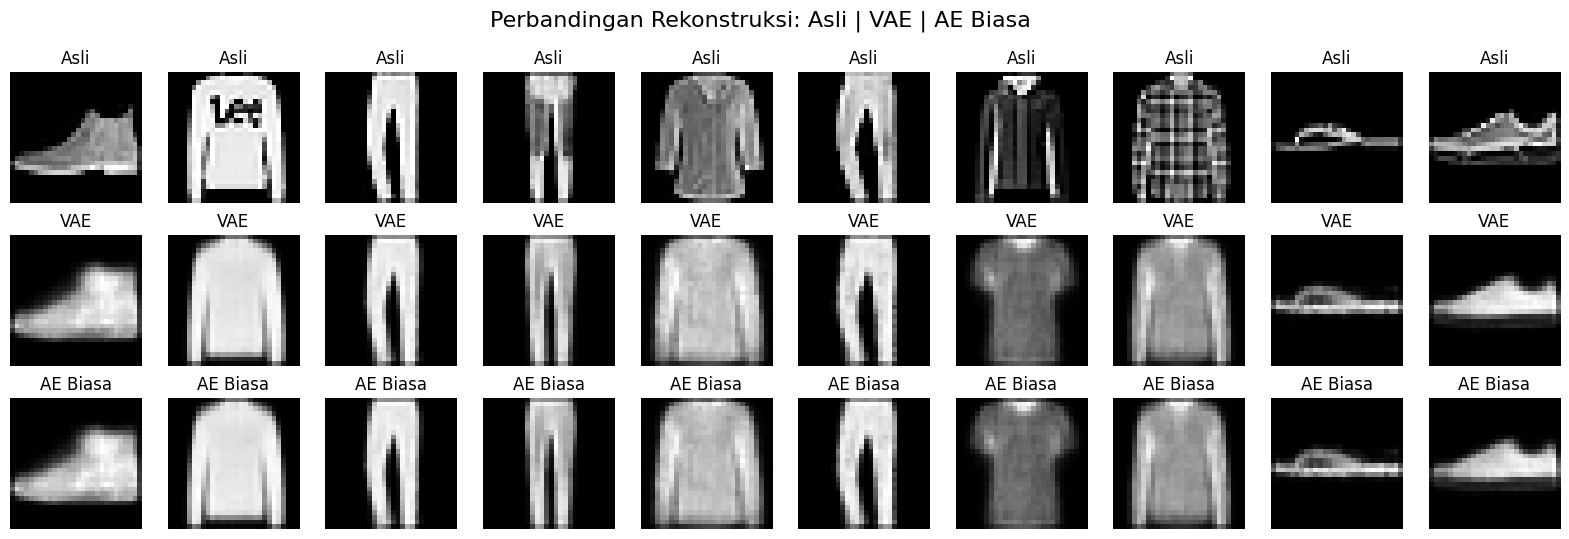


Analisis: AE Biasa (Baris Bawah) menghasilkan gambar yang umumnya lebih tajam, sedangkan VAE (Baris Tengah) menghasilkan rekonstruksi yang lebih lembut/kabur, menunjukkan kompromi antara kualitas rekonstruksi dan keteraturan latent space.


In [ ]:
print("\n--- [4. Perbandingan VAE vs. AE Biasa] ---")

# 1. Bangun AE Biasa
# AE hanya perlu Input, Encoder (tanpa 2 output mean/log_var), dan Decoder
ae_encoder_output = encoder.get_layer("z_mean").output # Ambil output mean (z) dari encoder VAE
ae_input = encoder.input
ae_latent = ae_encoder_output
ae_reconstruction = decoder(ae_latent)

ae = keras.Model(ae_input, ae_reconstruction, name='autoencoder')

# 2. Compile AE (Hanya menggunakan Reconstruction Loss: Binary Crossentropy)
ae.compile(optimizer='adam', loss='binary_crossentropy')

# 3. Latih AE
print("Mulai Pelatihan Autoencoder Biasa...")
# Input dan Target adalah x_train
ae.fit(x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
print("Pelatihan Autoencoder Biasa Selesai.")

# 4. Perbandingan Hasil Rekonstruksi
n_compare = 10
sample_images = x_test[:n_compare]

# Rekonstruksi oleh VAE (hanya butuh rekonstruksi dari call)
_, _, vae_reconstructions = vae.predict(sample_images)

# Rekonstruksi oleh AE
ae_reconstructions = ae.predict(sample_images)

# Visualisasi Perbandingan
plt.figure(figsize=(20, 6))
plt.suptitle("Perbandingan Rekonstruksi: Asli | VAE | AE Biasa", fontsize=16)

for i in range(n_compare):
    # Baris 1: Asli
    ax = plt.subplot(3, n_compare, i + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')
    ax.set_title("Asli")
    plt.axis("off")

    # Baris 2: Rekonstruksi VAE
    ax = plt.subplot(3, n_compare, i + 1 + n_compare)
    plt.imshow(vae_reconstructions[i].squeeze(), cmap='gray') # Removed .numpy()
    ax.set_title("VAE")
    plt.axis("off")

    # Baris 3: Rekonstruksi AE
    ax = plt.subplot(3, n_compare, i + 1 + 2 * n_compare)
    plt.imshow(ae_reconstructions[i].squeeze(), cmap='gray')
    ax.set_title("AE Biasa")
    plt.axis("off")

plt.show()

print("\nAnalisis: AE Biasa (Baris Bawah) menghasilkan gambar yang umumnya lebih tajam, sedangkan VAE (Baris Tengah) menghasilkan rekonstruksi yang lebih lembut/kabur, menunjukkan kompromi antara kualitas rekonstruksi dan keteraturan latent space.")